This practical work aims to implement different types of deep neural networks . 

The IMDB dataset, consisting of 50,000 movie reviews, serves as the basis for sentiment classification. The dataset includes two columns: "review," containing the text of the review, and "sentiment," indicating whether the sentiment is "positive" or "negative." 

The goal is to leverage Keras Embedding Layer and GloVe for word embedding, converting text into numerical representations for analysis.

In [102]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer


In [103]:
#Load dataset 
Dataset = pd.read_csv(r'C:\Users\Rania\Desktop\Machine learning\DL RT4\RNN\IMDB Dataset.csv')
print(Dataset.shape)
print (Dataset.iloc[:5])
# Print rows with null values
print(Dataset[Dataset.isnull().any(axis=1)])

(50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Empty DataFrame
Columns: [review, sentiment]
Index: []


In [104]:
Dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


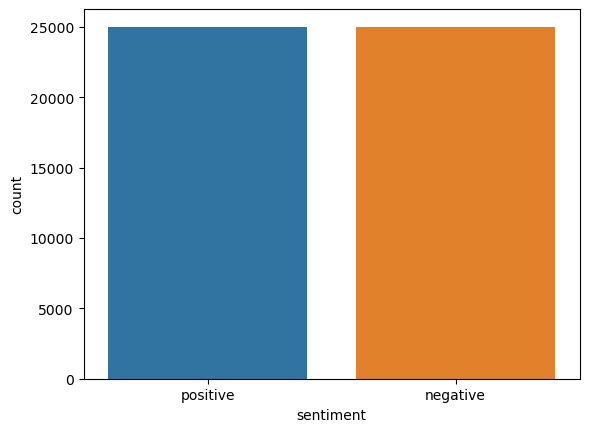

In [105]:
#Checking if the dataset is balanced
sns.countplot(x='sentiment', data=Dataset)
plt.show()

The heights of the bars are roughly equal, it indicates a balanced dataset !

In [106]:
#Printing the 4th review
print(Dataset['review'][3])

Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.


The review text contains a lot of insignificant html tags , special characters , ponctutations !

### Data preprocessing 

In [107]:
def preprocess_text(sen):
 # Removing html tags
 sentence = remove_tags(sen)
 # Remove punctuations and numbers
 sentence = re.sub('[^a-zA-Z]', ' ', sentence)
 # Single character removal
 sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
 # Removing multiple spaces
 sentence = re.sub(r'\s+', ' ', sentence)
 return sentence
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
 return TAG_RE.sub('', text)

In [108]:
X = []
sentences = list(Dataset['review'])
for sen in sentences:
 X.append(preprocess_text(sen))

In [109]:
#Printing the 4th review
print(X[3])

Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them 


We can observe that the review is clearer now after preprocessing the text

In [110]:
#Converting the classes into binairy values 
y = Dataset['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))


In [111]:
# Splitting data into training and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.20, random_state=42)


### Embedding Layer

This step involves using the Tokenizer class to tokenize the text data and create a word-to-index dictionary

In [112]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [113]:
#Sequence padding and truncation : ensuring that all sequences have the same length 
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#### We'll create a word embedding matrix using pre-trained GloVe word embeddings (Global Vectors for Word Representation)

GloVe embeddings are trained on large corpora, capturing the semantic meaning and relationships between words based on their co-occurrence patterns in the training data. The embeddings can then be used as features in downstream natural language processing models.

In [114]:
from numpy import array
from numpy import asarray
from numpy import zeros

# Create an empty dictionary to store word embeddings
embeddings_dictionary = dict()
glove_file = open(r"C:\Users\Rania\Desktop\Machine learning\DL RT4\RNN\glove.6B.100d.txt", encoding="utf8")
for line in glove_file:
#Split the line into words and their corresponding vector dimensions
 records = line.split()
# Extract the word (the first element in the line)
 word = records[0]
# Extract the vector dimensions and convert them to a NumPy array of floats
 vector_dimensions = asarray(records[1:],dtype='float32')
# Store the word and its vector dimensions in the dictionary
 embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [115]:
#Initialization of Embedding Matrix:
embedding_matrix = zeros((vocab_size, 100))
#Populating the Embedding Matrix:
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Classification with a simple neural network

In [116]:
model= Sequential()
# create model
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix],
input_length=maxlen , trainable=False))
model.add(Flatten())
model.add(Dense(units=1,activation='sigmoid'))
#compile model
model.compile(  optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
#train the model
history= model.fit(X_train, y_train, epochs=6, batch_size=128,verbose=1,validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 7s 15ms/step - loss: 0.6092 - acc: 0.6661 - val_loss: 0.5541 - val_acc: 0.7171
Epoch 2/6
250/250 [==============================] - 4s 16ms/step - loss: 0.4993 - acc: 0.7582 - val_loss: 0.5187 - val_acc: 0.7401
Epoch 3/6
250/250 [==============================] - 2s 10ms/step - loss: 0.4607 - acc: 0.7835 - val_loss: 0.5174 - val_acc: 0.7475
Epoch 4/6
250/250 [==============================] - 2s 9ms/step - loss: 0.4416 - acc: 0.7947 - val_loss: 0.5377 - val_acc: 0.7346
Epoch 5/6
250/250 [==============================] - 2s 9ms/step - loss: 0.4253 - acc: 0.8057 - val_loss: 0.5371 - val_acc: 0.7394
Epoch 6/6
250/250 [==============================] - 2s 8ms/step - loss: 0.4111 - acc: 0.8138 - val_loss: 0.5582 - val_acc: 0.7321


In [117]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 2s 2ms/step - loss: 0.5583 - acc: 0.7345
Test Score: 0.5583090782165527
Test Accuracy: 0.734499990940094


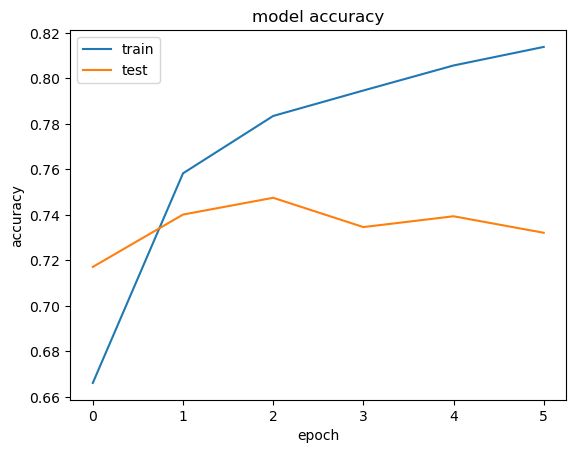

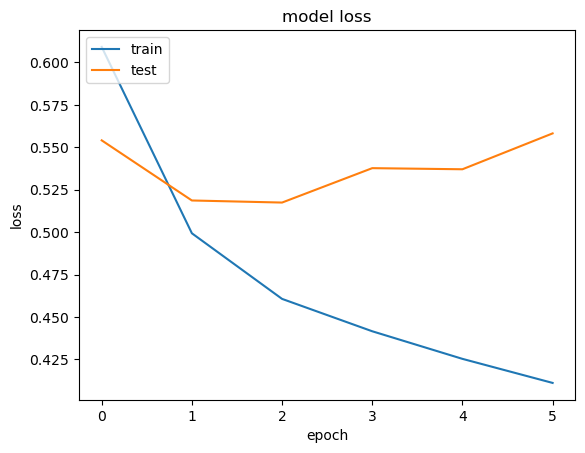

In [118]:
#Plot Accuracy and Loss

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


### Classification with a convolutional neural network

In [122]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense

# Model
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False))
model.add(Conv1D(filters=128, kernel_size=5,activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(1,activation="sigmoid"))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

#train the model
history= model.fit(X_train, y_train, epochs=6, batch_size=128,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 20s 62ms/step - loss: 0.5072 - acc: 0.7479 - val_loss: 0.4011 - val_acc: 0.8166
Epoch 2/6
250/250 [==============================] - 15s 61ms/step - loss: 0.3709 - acc: 0.8351 - val_loss: 0.3672 - val_acc: 0.8349
Epoch 3/6
250/250 [==============================] - 15s 61ms/step - loss: 0.3185 - acc: 0.8648 - val_loss: 0.3526 - val_acc: 0.8391
Epoch 4/6
250/250 [==============================] - 15s 59ms/step - loss: 0.2899 - acc: 0.8805 - val_loss: 0.3939 - val_acc: 0.8234
Epoch 5/6
250/250 [==============================] - 17s 70ms/step - loss: 0.2537 - acc: 0.9006 - val_loss: 0.3434 - val_acc: 0.8462
Epoch 6/6
250/250 [==============================] - 18s 73ms/step - loss: 0.2174 - acc: 0.9194 - val_loss: 0.4008 - val_acc: 0.8219


In [120]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 5s 7ms/step - loss: 0.3467 - accuracy: 0.8435
Test Score: 0.3466976583003998
Test Accuracy: 0.843500018119812


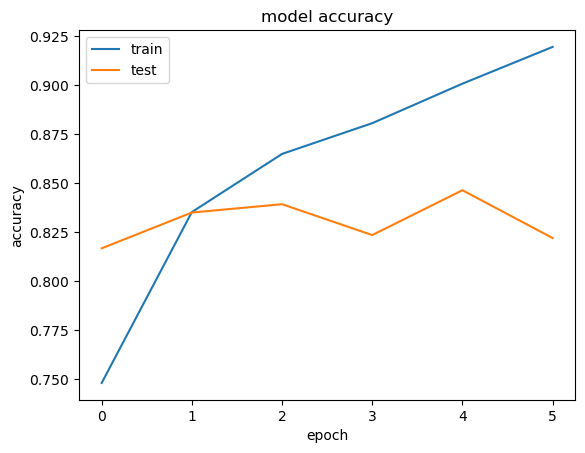

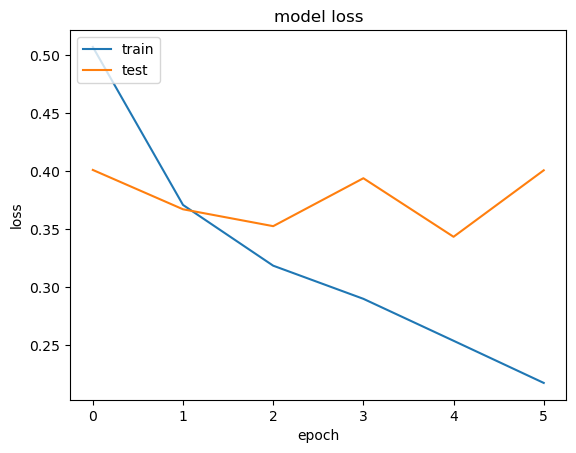

In [123]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Classification with Reccurent Neural Network LSTM

In [124]:
#Model 
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False))
model.add(LSTM(128))
model.add(Dense(1,activation="sigmoid"))
#Compile
model.compile(optimizer="adam", metrics=['acc'], loss="binary_crossentropy")
#Train 
history= model.fit(X_train, y_train, batch_size=128,  epochs=6, verbose=1, validation_split= 0.2)

Epoch 1/6
250/250 [==============================] - 61s 221ms/step - loss: 0.5632 - acc: 0.6977 - val_loss: 0.4524 - val_acc: 0.7895
Epoch 2/6
250/250 [==============================] - 61s 245ms/step - loss: 0.4451 - acc: 0.7944 - val_loss: 0.4219 - val_acc: 0.8142
Epoch 3/6
250/250 [==============================] - 59s 236ms/step - loss: 0.4040 - acc: 0.8164 - val_loss: 0.4036 - val_acc: 0.8189
Epoch 4/6
250/250 [==============================] - 61s 244ms/step - loss: 0.3716 - acc: 0.8346 - val_loss: 0.3716 - val_acc: 0.8338
Epoch 5/6
250/250 [==============================] - 50s 202ms/step - loss: 0.3461 - acc: 0.8475 - val_loss: 0.3577 - val_acc: 0.8425
Epoch 6/6
250/250 [==============================] - 55s 219ms/step - loss: 0.3239 - acc: 0.8576 - val_loss: 0.3637 - val_acc: 0.8407


In [125]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 13s 31ms/step - loss: 0.3595 - acc: 0.8380
Test Score: 0.359500527381897
Test Accuracy: 0.8379999995231628


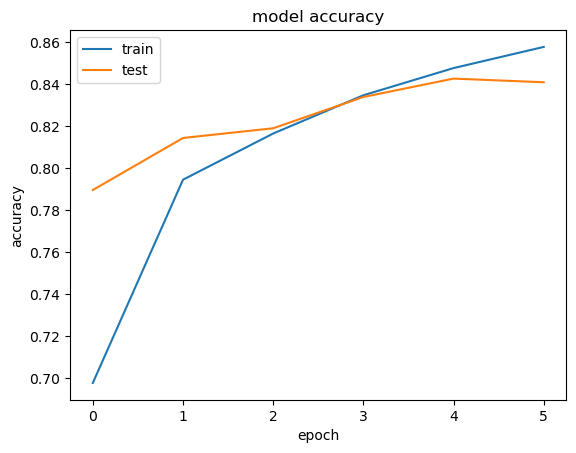

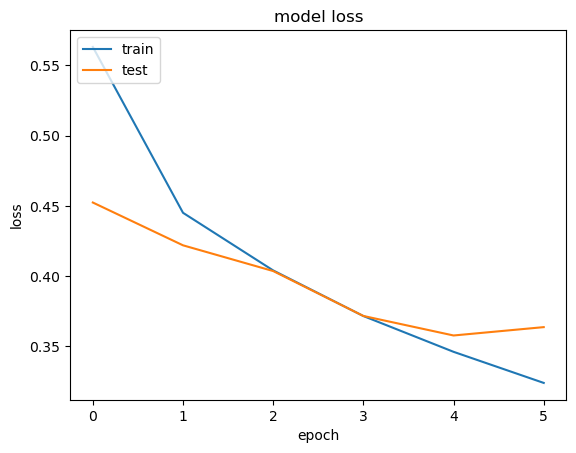

In [127]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [128]:
print(X[3])

Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them 


In [129]:
y[3]

0

In [132]:
predicted = tokenizer.texts_to_sequences([X[20]])
text = pad_sequences(predicted,padding='post',maxlen=maxlen)
model.predict(text)

1/1 [==============================] - 5s 5s/step


array([[0.72593117]], dtype=float32)

The prediction is accurate (less than 0.5)

In [131]:
#Trying with a text
exp="I like this movie very much"
predicted = tokenizer.texts_to_sequences([exp])
text = pad_sequences(predicted,padding='post',maxlen=maxlen)
model.predict(text)

1/1 [==============================] - 4s 4s/step


array([[0.9821693]], dtype=float32)

The prediction is once again accurate: positive feedback ( greater than 0.5)

### Classification with GRU

In [134]:
from tensorflow.keras.layers import GRU
#Model
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False))
model.add(GRU(128))
model.add(Dense(1,activation="sigmoid"))
#Compile
model.compile(optimizer="adam", metrics=['acc'], loss="binary_crossentropy")
#Train
history= model.fit(X_train, y_train, batch_size=128,  epochs=6, verbose=1, validation_split= 0.2)

Epoch 1/6
250/250 [==============================] - 47s 170ms/step - loss: 0.5404 - acc: 0.7151 - val_loss: 0.4128 - val_acc: 0.8110
Epoch 2/6
250/250 [==============================] - 39s 156ms/step - loss: 0.3990 - acc: 0.8177 - val_loss: 0.3742 - val_acc: 0.8301
Epoch 3/6
250/250 [==============================] - 41s 165ms/step - loss: 0.3721 - acc: 0.8340 - val_loss: 0.3500 - val_acc: 0.8446
Epoch 4/6
250/250 [==============================] - 41s 164ms/step - loss: 0.3425 - acc: 0.8493 - val_loss: 0.3367 - val_acc: 0.8481
Epoch 5/6
250/250 [==============================] - 38s 152ms/step - loss: 0.3232 - acc: 0.8582 - val_loss: 0.3327 - val_acc: 0.8505
Epoch 6/6
250/250 [==============================] - 38s 151ms/step - loss: 0.3043 - acc: 0.8678 - val_loss: 0.3216 - val_acc: 0.8574


In [135]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 11s 28ms/step - loss: 0.3191 - acc: 0.8627
Test Score: 0.3190949261188507
Test Accuracy: 0.8626999855041504


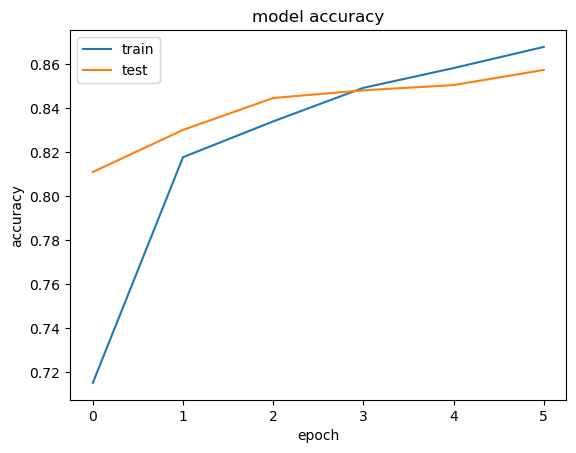

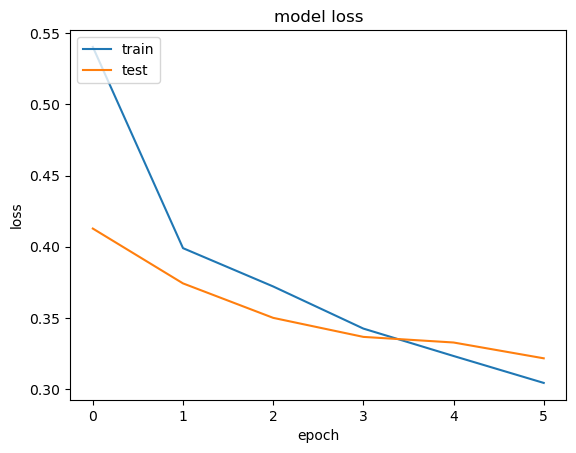

In [136]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Classification with RNN + CNN


In [137]:
from tensorflow.keras.layers import SimpleRNN
#Model
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False))
model.add(SimpleRNN(128,return_sequences=True))
model.add(Conv1D(filters=128, kernel_size=5,activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(1,activation="sigmoid"))
#Compile 
model.compile(optimizer="adam", metrics=['acc'], loss="binary_crossentropy")
#Train
history= model.fit(X_train, y_train, batch_size=128,  epochs=6, verbose=1, validation_split= 0.2)

Epoch 1/6
250/250 [==============================] - 39s 139ms/step - loss: 0.5003 - acc: 0.7472 - val_loss: 0.4107 - val_acc: 0.8076
Epoch 2/6
250/250 [==============================] - 36s 144ms/step - loss: 0.3695 - acc: 0.8365 - val_loss: 0.3747 - val_acc: 0.8296
Epoch 3/6
250/250 [==============================] - 34s 135ms/step - loss: 0.3207 - acc: 0.8622 - val_loss: 0.3941 - val_acc: 0.8160
Epoch 4/6
250/250 [==============================] - 32s 128ms/step - loss: 0.2784 - acc: 0.8869 - val_loss: 0.3671 - val_acc: 0.8351
Epoch 5/6
250/250 [==============================] - 35s 139ms/step - loss: 0.2363 - acc: 0.9075 - val_loss: 0.3883 - val_acc: 0.8274
Epoch 6/6
250/250 [==============================] - 38s 153ms/step - loss: 0.1990 - acc: 0.9270 - val_loss: 0.3830 - val_acc: 0.8346


In [138]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 8s 18ms/step - loss: 0.3723 - acc: 0.8390
Test Score: 0.3722969591617584
Test Accuracy: 0.8389999866485596


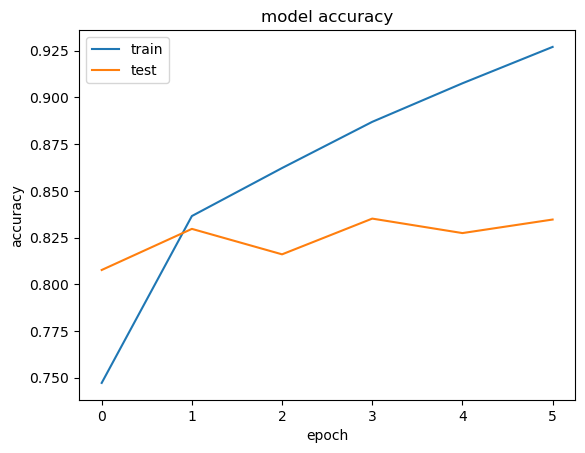

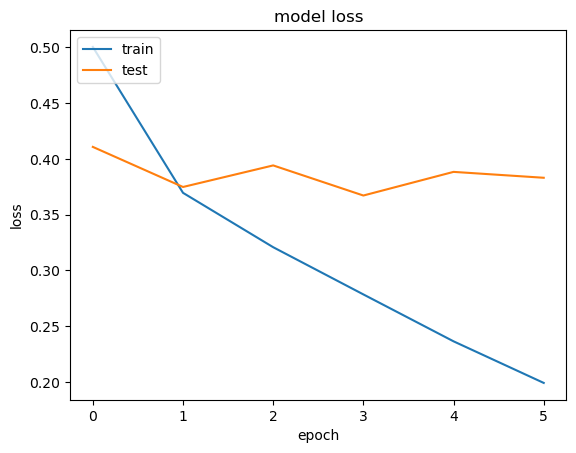

In [139]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [5]:
import pandas as pd

columns = ['NN', 'CNN', 'LSTM', 'GRU', 'CNN+RNN']
comparison = pd.DataFrame(index=["Accuracy"], columns=columns)
comparison["NN"] = [0.734499990940094]
comparison["CNN"] = [0.843500018119812]
comparison["LSTM"] = [0.8379999995231628]
comparison["GRU"] = [0.8626999855041504]
comparison["CNN+RNN"] = [0.8389999866485596]
comparison.head()

,NN,CNN,LSTM,GRU,CNN+RNN
Accuracy,0.7345,0.8435,0.838,0.8627,0.839


It seems like the GRU is the most efficient among the 5 models we've created since it's giving the highest accuracy 